In [1]:
# Import packages
import os,keras,cv2
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import datetime
from keras import layers,losses,callbacks,activations,regularizers,metrics,applications,optimizers

In [ ]:
# Load data
IMG_DATA = os.path.join('concrete_dataset')
batch_size = 10
IMG_SIZE = (160,160)

In [ ]:
# Split data
seed = 69
train_dataset,validation_dataset = keras.utils.image_dataset_from_directory(IMG_DATA,
                                                        shuffle=True,
                                                        batch_size=batch_size,
                                                        image_size=IMG_SIZE,
                                                        validation_split=0.3,
                                                        subset='both',
                                                        seed=seed)

Found 40000 files belonging to 2 classes.
Using 28000 files for training.
Using 12000 files for validation.


['with_cracks', 'without_cracks']


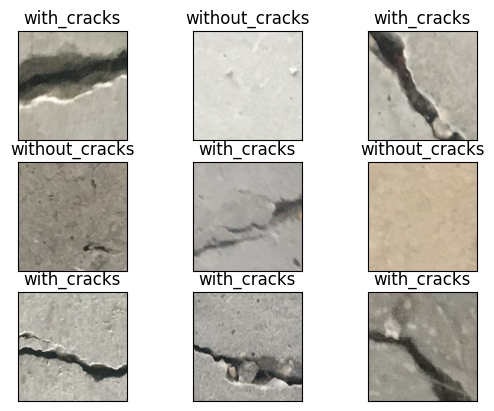

In [ ]:
# Inspect some data samples from the dataset
class_names = train_dataset.class_names
print(class_names)
batch_1 = train_dataset.take(1)
for feature, label in batch_1:
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(feature[i].numpy().astype('uint8'))
        plt.title(class_names[label[i]])
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
    plt.show()

In [ ]:
# Split the validation dataset into 2 equal splits: for val and test
nBatches = validation_dataset.cardinality().numpy()
print(nBatches)
val_dataset = validation_dataset.take(nBatches//2)
test_dataset = validation_dataset.skip(nBatches//2)

1200


In [ ]:
# Convert the val and test dataset back to PrefetchDataset
val_dataset = val_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
# Create a sequential model for augmentation
data_augmentation = keras.Sequential()
data_augmentation.add(layers.RandomFlip())
data_augmentation.add(layers.RandomRotation(factor=0.2))

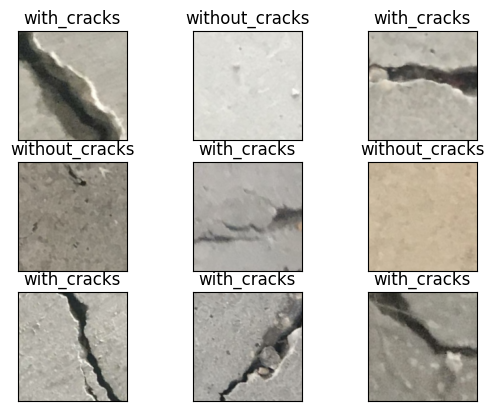

In [ ]:
# Inspect some data samples from the dataset after augmentation
feature_augmented = data_augmentation(feature)
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(feature_augmented[i].numpy().astype('uint8'))
    plt.title(class_names[label[i]])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
plt.show()

In [ ]:
# Create the preprocessing layer based on the pretrained model
preprocess_input = applications.mobilenet_v2.preprocess_input

In [ ]:
# Apply transfer learning
# Load in the pretrained model as feature extractor
IMG_SHAPE = IMG_SIZE + (3,)
base_model = applications.MobileNetV2(input_shape=IMG_SHAPE,include_top=False,weights="imagenet")
# Freeze the entire feature extractor
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_160"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 80, 80,    │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 80, 80,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 80, 80,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 80, 80,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 80, 80,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 80, 80,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 81, 81,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 40, 40,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 40, 40,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
# Construct the classifier
global_avg = layers.GlobalAveragePooling2D()
output_layer = layers.Dense(len(class_names),activation='softmax')

In [ ]:
# Use functional API to connect all the layers together
inputs = keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x)
x = global_avg(x)
outputs = output_layer(x)
model = keras.Model(inputs=inputs,outputs=outputs)
model.summary()
keras.utils.plot_model(model)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │         2,562 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,260,546 (8.62 MB)

 Trainable params: 2,562 (10.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


In [ ]:
# Compile the model
optimizers = optimizers.Adam(learning_rate=0.0001)
loss = losses.SparseCategoricalCrossentropy()
model.compile(optimizer=optimizers,loss=loss,metrics=['accuracy'])

In [ ]:
# Train the model
logpath = os.path.join("concrete_class_log",datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
print(logpath)
tb = callbacks.TensorBoard(log_dir=logpath)
es = callbacks.EarlyStopping(patience=3,verbose=1)

concrete_class_log\20250312-123339


In [ ]:
# Evaluate the model before training
model.evaluate(test_dataset)

600/600 ━━━━━━━━━━━━━━━━━━━━ 28s 42ms/step - accuracy: 0.5333 - loss: 1.0150


[1.018053650856018, 0.5299999713897705]

In [ ]:
# Model first training
EPOCHS = 10
history_1 = model.fit(train_dataset,validation_data=val_dataset,epochs=EPOCHS,callbacks=[tb,es])

Epoch 1/10
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 166s 58ms/step - accuracy: 0.9713 - loss: 0.0860 - val_accuracy: 0.9975 - val_loss: 0.0094
Epoch 2/10
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 162s 58ms/step - accuracy: 0.9974 - loss: 0.0092 - val_accuracy: 0.9975 - val_loss: 0.0081
Epoch 3/10
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 161s 57ms/step - accuracy: 0.9979 - loss: 0.0074 - val_accuracy: 0.9982 - val_loss: 0.0067
Epoch 4/10
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 166s 59ms/step - accuracy: 0.9982 - loss: 0.0070 - val_accuracy: 0.9983 - val_loss: 0.0058
Epoch 5/10
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 170s 61ms/step - accuracy: 0.9984 - loss: 0.0058 - val_accuracy: 0.9978 - val_loss: 0.0069
Epoch 6/10
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 175s 63ms/step - accuracy: 0.9984 - loss: 0.0050 - val_accuracy: 0.9980 - val_loss: 0.0063
Epoch 7/10
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 188s 67ms/step - accuracy: 0.9988 - loss: 0.0054 - val_accuracy: 0.9982 - val_loss: 0.0054
Epoch 8/10
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 221s 79ms/step - accuracy: 

In [ ]:
# Save first training model
model.save('model/model1.keras')

In [ ]:
# Evaluate the first training model
model.evaluate(test_dataset)

600/600 ━━━━━━━━━━━━━━━━━━━━ 43s 70ms/step - accuracy: 0.9987 - loss: 0.0052


[0.005912188906222582, 0.9983333349227905]

In [ ]:
# Second stage transfer learning
# Unfreeze the base model
base_model.trainable = True
# Free the earlier layers of the base model
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_160"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 80, 80,    │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 80, 80,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 80, 80,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 80, 80,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 80, 80,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 80, 80,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 81, 81,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 40, 40,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 40, 40,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 1,861,440 (7.10 MB)

 Non-trainable params: 396,544 (1.51 MB)

In [ ]:
# Recompile the model and retrain 
rmsprop = keras.optimizers.RMSprop(learning_rate=0.00001)
model.compile(optimizer=rmsprop,loss=loss,metrics=['accuracy'])

In [ ]:
# Get latest epoch for first model 
history_1.epoch[-1]

9

In [22]:
# Run the second stage training
second_epochs = 10
total_epochs = EPOCHS + second_epochs
starting_epoch = history_1.epoch[-1] + 1
history_2 = model.fit(train_dataset,validation_data=val_dataset,epochs=total_epochs,initial_epoch=starting_epoch,callbacks=[tb])

Epoch 11/20
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 270s 94ms/step - accuracy: 0.9490 - loss: 0.1552 - val_accuracy: 0.9988 - val_loss: 0.0041
Epoch 12/20
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 248s 89ms/step - accuracy: 0.9917 - loss: 0.0319 - val_accuracy: 0.9990 - val_loss: 0.0036
Epoch 13/20
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 262s 94ms/step - accuracy: 0.9975 - loss: 0.0086 - val_accuracy: 0.9983 - val_loss: 0.0040
Epoch 14/20
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 283s 101ms/step - accuracy: 0.9979 - loss: 0.0100 - val_accuracy: 0.9987 - val_loss: 0.0032
Epoch 15/20
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 295s 105ms/step - accuracy: 0.9976 - loss: 0.0098 - val_accuracy: 0.9988 - val_loss: 0.0033
Epoch 16/20
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 308s 110ms/step - accuracy: 0.9980 - loss: 0.0092 - val_accuracy: 0.9987 - val_loss: 0.0037
Epoch 17/20
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 322s 115ms/step - accuracy: 0.9980 - loss: 0.0081 - val_accuracy: 0.9988 - val_loss: 0.0034
Epoch 18/20
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 341s 122ms/step

In [23]:
# Evaluate the model after the second stage of transfer learning
model.evaluate(test_dataset)

600/600 ━━━━━━━━━━━━━━━━━━━━ 47s 77ms/step - accuracy: 0.9994 - loss: 0.0017


[0.0020712576806545258, 0.9993333220481873]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 933ms/step
['with_cracks', 'with_cracks', 'without_cracks', 'with_cracks', 'without_cracks', 'without_cracks', 'without_cracks', 'with_cracks', 'without_cracks', 'without_cracks']


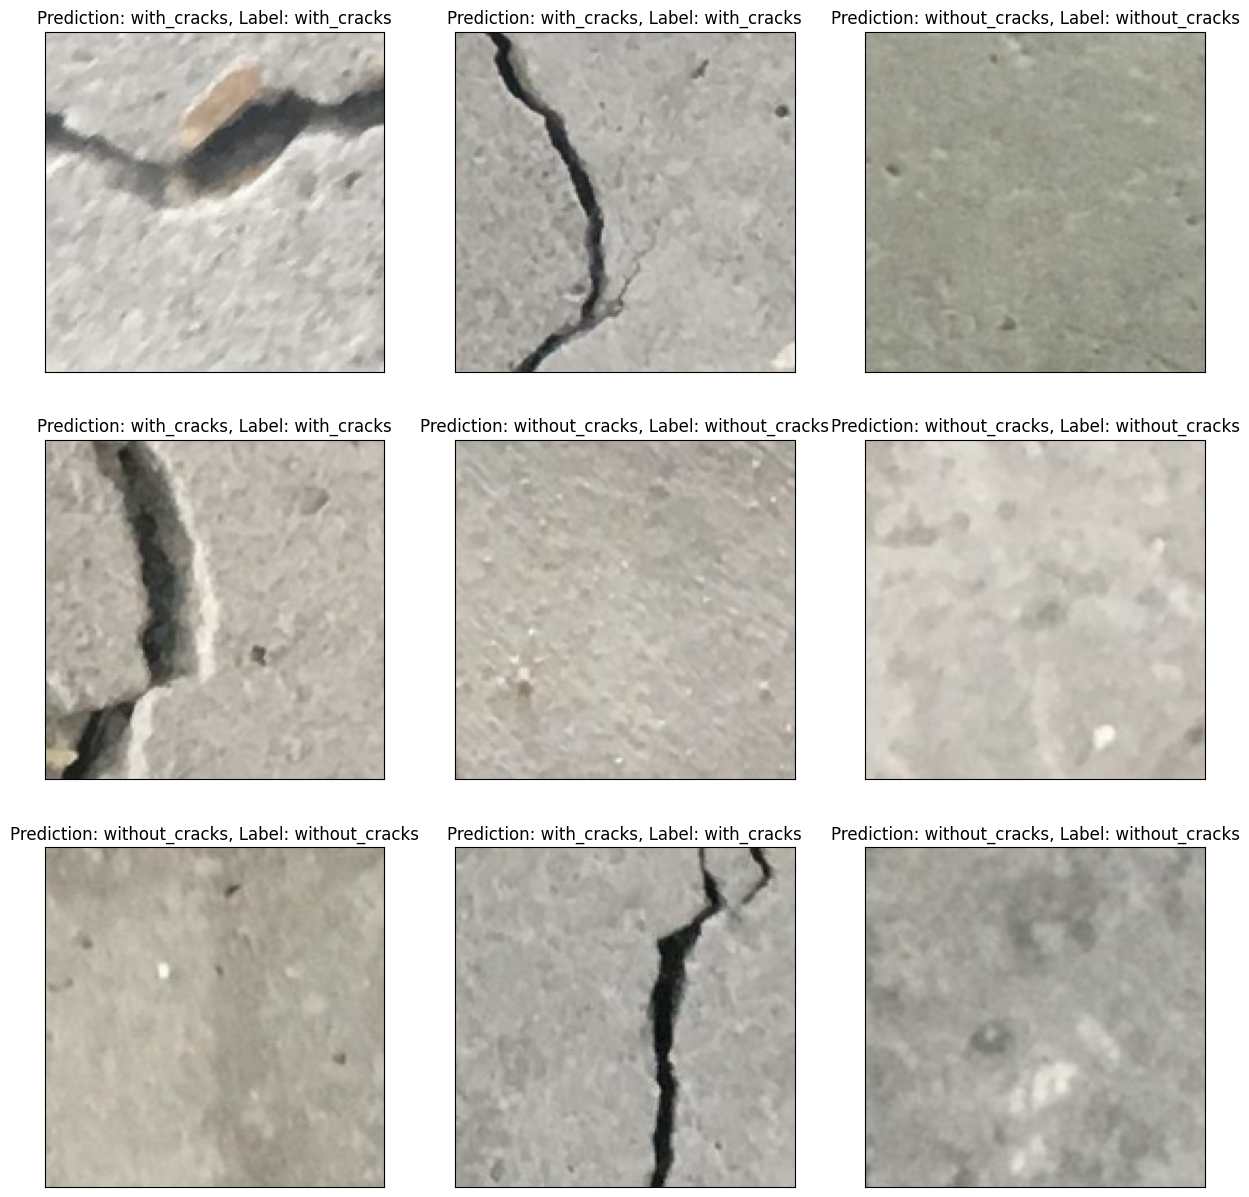

In [24]:
# Use the model to make prediction
for image_batch,label_batch in test_dataset.take(1):
    y_pred = np.argmax(model.predict(image_batch),axis=1)
    predicted_class = [class_names[x] for x in y_pred]
print(predicted_class)

plt.figure(figsize=(15,15))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(image_batch[i].numpy().astype('uint8'))
    plt.title(f"Prediction: {predicted_class[i]}, Label: {class_names[label_batch[i]]}")
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
plt.show()

In [ ]:
# Save model after second training
model.save('model/model2.keras')